# HPC 2022, ЛР2 VectorSum, Одобеску Роман 6132
Данная ЛР посвящена реализации нахождения суммы вектора с использованием CUDA. В рамках данной ЛР также будет произведены сравнения следующих реализаций:
* на GPU (С++)
* на CPU (С++)
* на GPU через PyTorch (Python)
* на CPU через NumPy (Python)

Вся визуализация будет выполнена через Python. Данные для визуализации из C++ получаются путём копирования из вывода соответствующей ячейки.

# Установка nvcc

Проверка доступных GPU

In [9]:
!nvidia-smi

Sun Dec 11 14:19:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    32W / 250W |   2717MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Установка nvcc плагина для Jupyter

In [10]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-u2x7hgw9
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-u2x7hgw9
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4306 sha256=1a94ef900ac396d1f3c16d95b6dd87cd9815fca6be48bc27931f006eba66a2c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-msvrbji1/wheels/ca/33/8d/3c86eb85e97d2b6169d95c6e8f2c297fdec60db6e84cb56f5e
Successfully built NVCCPlugin


In [11]:
%load_ext nvcc_plugin

created output directory at /kaggle/working/src
Out bin /kaggle/working/result.out


In [12]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


# Основная часть на С++

In [24]:
%%cu
#include <cstdio>
#include <iostream>
#include "assert.h"
#include <time.h>
using namespace std;

#define BLOCK_SIZE 1024
int N = 134217728;


// Если cudaError_t, который вернула cuda-функция, не cudaSuccess, то выводит обнаруженную ошибку
void err_check(cudaError_t error){
    if (error != cudaSuccess){
        cout << "Error" << endl;
        cerr << cudaGetErrorString(error) << endl;
        exit(1);
    }
}

__global__ void reduce4(int* inData, int* outData)
{
    __shared__ int data[BLOCK_SIZE];
    int tid = threadIdx.x;
    int i = 2 * blockIdx.x * blockDim.x + threadIdx.x;

    data[tid] = inData[i] + inData[i+blockDim.x];      // load into shared memeory

    __syncthreads();

    for (int s = blockDim.x/2; s>0; s>>=1 )
    {
        if (tid < s)
           data[tid] += data[tid + s];

        __syncthreads();
    }

    if (tid == 0)                                       // write result of block reduction
        outData[blockIdx.x] = data[0];
}


long clp2(long x) {
 long p2=1;
 while (1) {
  if (p2>=x) return p2;
  p2<<=1;
 }
 return 0;
}


int main(int argc, char *  argv[])
{
    int nearest_power_of_2 = clp2(N);
    
    int * a = new int[nearest_power_of_2];
    int * b = new int[nearest_power_of_2];

    int n = nearest_power_of_2;
    int numBytes = n * sizeof(int);
    
    for (int i = 0; i < N; i++)
    {
        a[i] = (rand() & 0xFF) - 127; //(rand() & 0xFF) - 127;
    }
    
    double cpu_time;
    int sum = 0;
    
    clock_t start_cpu, end_cpu;
    start_cpu = clock();
    
    for (int i = 0; i < N; i++){
        sum  += a[i];
    }
    
    end_cpu = clock();
    cpu_time = 1.0f * (end_cpu - start_cpu) / CLOCKS_PER_SEC;
    printf("time spent executing cpu: %lf milliseconds\n",cpu_time*1000);
    
    for (int i = N; i < nearest_power_of_2; i++){
        a[i] = 0;
    }

    int* adev[2] = { NULL, NULL };
    cudaEvent_t start, stop;
    float gpuTime = 0.0f;

    err_check(cudaMalloc((void**)&adev[0], numBytes));
    err_check(cudaMalloc((void**)&adev[1], numBytes));
    
    err_check(cudaMemcpy(adev[0], a, numBytes, cudaMemcpyHostToDevice));

    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start, 0);
    
    
    int grid_size = n / (2*BLOCK_SIZE);
    
    if(grid_size==0){
       grid_size=1; 
    }
       
    dim3 dimBlock(BLOCK_SIZE, 1, 1);
    dim3 dimGrid(grid_size, 1, 1);

    reduce4<<<dimGrid, dimBlock>>>(adev[0], adev[1]);

    err_check(cudaDeviceSynchronize());
    
    // n/=(2*BLOCK_SIZE);
    
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&gpuTime, start, stop);
    
    cudaMemcpy(b, adev[1], numBytes, cudaMemcpyDeviceToHost);

    for (int i = 1; i < grid_size; i++){
        b[0] += b[i];
    }
    
    // print the cpu and gpu times
    printf("time spent executing by the GPU: %.4f milliseconds\n", gpuTime);
    printf("CPU sum %d, CUDA sum %d, N = %d\n", sum, b[0], N);

    // release resources
    cudaEventDestroy(start);
    cudaEventDestroy(stop);
    cudaFree(adev[0]);
    cudaFree(adev[1]);

    delete a;
    delete b;

    return 0;
}

time spent executing cpu: 334.381998 milliseconds
time spent executing by the GPU: 3.7522 milliseconds
CPU sum 67968979, CUDA sum 67968979, N = 134217728



# Python (NumPy, PyTorch)

In [25]:
import torch
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

In [26]:
time_list_c_cpu = [0.363000, 0.658000, 1.270000, 2.472000, 5.052000, 9.947000, 21.284999, 41.464999, 80.723003, 161.990002, 334.381998]
time_list_c_gpu = [0.0265, 0.0289, 0.0354, 0.0504, 0.0820, 0.1433, 0.2569, 0.4891, 0.9576, 1.8888, 3.7522]

In [27]:
np.random.seed(42)
time_list_numpy = list()
for dim in [131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432, 67108864, 134217728]:
    mas = np.random.randint(-127, 127, dim)
    avg_time=0
    for j in range(10):
        start = time.time()
        s = np.sum(mas)
        stop = time.time()
        avg_time+=(stop-start)
    avg_time/=10
    time_list_numpy.append(avg_time*1000)
print(f'\'numpy_time\': {time_list_numpy}')

'numpy_time': [0.1322031021118164, 0.1896381378173828, 0.3351926803588867, 0.6592750549316406, 1.3870716094970703, 3.0961990356445312, 7.091498374938965, 14.714813232421875, 29.715251922607422, 59.682488441467285, 119.69974040985107]


In [28]:
np.random.seed(42)
time_list_torch_cpu = list()
for dim in [131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432, 67108864, 134217728]:
    mas = torch.tensor(np.random.randint(-127, 127, dim))
    avg_time=0
    for j in range(10):
        start = time.time()
        s = torch.sum(mas)
        stop = time.time()
        avg_time+=(stop-start)
    avg_time/=10
    time_list_torch_cpu.append(avg_time*1000)
print(f'\'torch_cpu_time\': {time_list_torch_cpu}')

'torch_cpu_time': [0.04832744598388672, 0.11134147644042969, 0.1827239990234375, 0.35228729248046875, 0.7841587066650391, 1.8709421157836914, 5.008149147033691, 10.68127155303955, 23.559021949768066, 44.33009624481201, 109.26220417022705]


In [29]:
np.random.seed(42)
time_list_torch_gpu = list()
for dim in [131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432, 67108864, 134217728]:
    mas = torch.tensor(np.random.randint(-127, 127, dim)).to('cuda:0')
    avg_time=0
    for j in range(10):
        start = time.time()
        s = torch.sum(mas)
        stop = time.time()
        avg_time+=(stop-start)
    avg_time/=10
    time_list_torch_gpu.append(avg_time*1000)
print(f'\'torch_gpu_time\': {time_list_torch_gpu}')

'torch_gpu_time': [0.04024505615234375, 0.046372413635253906, 0.023818016052246094, 0.02110004425048828, 0.034117698669433594, 0.022745132446289062, 0.02243518829345703, 0.02319812774658203, 0.023317337036132812, 0.025272369384765625, 0.03638267517089844]


In [44]:
params = {
    'dim':         [131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432, 67108864, 134217728],
    'cpu_time (ms)':     time_list_c_cpu,
    'gpu_time (ms)':     time_list_c_gpu,
    'pytorch_cpu_time (ms)': time_list_torch_cpu,
    'pytorch_gpu_time (ms)': time_list_torch_gpu,
    'numpy_time (ms)': time_list_numpy
}

exp_count = len(params["dim"])

In [45]:
import pandas as pd

In [46]:
pd.DataFrame(params)

,dim,cpu_time (ms),gpu_time (ms),pytorch_cpu_time (ms),pytorch_gpu_time (ms),numpy_time (ms)
0,131072,0.363000,0.0265,0.048327,0.040245,0.132203
1,262144,0.658000,0.0289,0.111341,0.046372,0.189638
2,524288,1.270000,0.0354,0.182724,0.023818,0.335193
3,1048576,2.472000,0.0504,0.352287,0.021100,0.659275
4,2097152,5.052000,0.0820,0.784159,0.034118,1.387072
5,4194304,9.947000,0.1433,1.870942,0.022745,3.096199
6,8388608,21.284999,0.2569,5.008149,0.022435,7.091498
7,16777216,41.464999,0.4891,10.681272,0.023198,14.714813
8,33554432,80.723003,0.9576,23.559022,0.023317,29.715252
9,67108864,161.990002,1.8888,44.330096,0.025272,59.682488


<AxesSubplot:title={'center':'Ускорение GPU (C++) относительно CPU (C++)'}, xlabel='Размерность', ylabel='Ускорение'>

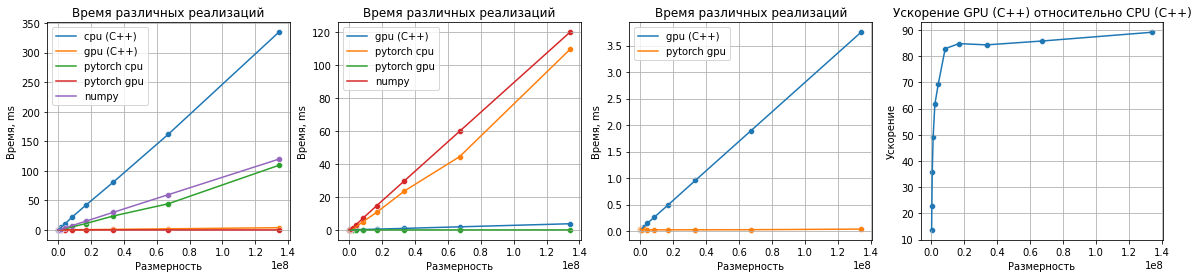

In [48]:
A = np.array(params['dim'])
gpu_time = np.array(params['gpu_time (ms)'])
cpu_time = np.array(params['cpu_time (ms)'])
pytorch_cpu_time = np.array(params['pytorch_cpu_time (ms)'])
pytorch_gpu_time = np.array(params['pytorch_gpu_time (ms)'])
numpy_time = np.array(params['numpy_time (ms)'])

speed_ratio = cpu_time / gpu_time

fig, axs = plt.subplots(ncols=4, figsize=(20, 4))

axs[0].set_title("Время различных реализаций")
axs[0].set_xlabel("Размерность")
axs[0].set_ylabel("Время, ms")
axs[0].grid()
sns.scatterplot(x=A, y=cpu_time, ax=axs[0])
sns.scatterplot(x=A, y=gpu_time, ax=axs[0])
sns.scatterplot(x=A, y=pytorch_cpu_time, ax=axs[0])
sns.scatterplot(x=A, y=pytorch_gpu_time, ax=axs[0])
sns.scatterplot(x=A, y=numpy_time, ax=axs[0])
sns.lineplot(x=A, y=cpu_time, ax=axs[0], label="cpu (C++)")
sns.lineplot(x=A, y=gpu_time, ax=axs[0], label="gpu (C++)")
sns.lineplot(x=A, y=pytorch_cpu_time, ax=axs[0], label="pytorch cpu")
sns.lineplot(x=A, y=pytorch_gpu_time, ax=axs[0], label="pytorch gpu")
sns.lineplot(x=A, y=numpy_time, ax=axs[0], label="numpy")

axs[1].set_title("Время различных реализаций")
axs[1].set_xlabel("Размерность")
axs[1].set_ylabel("Время, ms")
axs[1].grid()
sns.scatterplot(x=A, y=gpu_time, ax=axs[1])
sns.scatterplot(x=A, y=pytorch_cpu_time, ax=axs[1])
sns.scatterplot(x=A, y=pytorch_gpu_time, ax=axs[1])
sns.scatterplot(x=A, y=numpy_time, ax=axs[1])
sns.lineplot(x=A, y=gpu_time, ax=axs[1], label="gpu (C++)")
sns.lineplot(x=A, y=pytorch_cpu_time, ax=axs[1], label="pytorch cpu")
sns.lineplot(x=A, y=pytorch_gpu_time, ax=axs[1], label="pytorch gpu")
sns.lineplot(x=A, y=numpy_time, ax=axs[1], label="numpy")

axs[2].set_title("Время различных реализаций")
axs[2].set_xlabel("Размерность")
axs[2].set_ylabel("Время, ms")
axs[2].grid()
sns.scatterplot(x=A, y=gpu_time, ax=axs[2])
sns.scatterplot(x=A, y=pytorch_gpu_time, ax=axs[2])
sns.lineplot(x=A, y=gpu_time, ax=axs[2], label="gpu (C++)")
sns.lineplot(x=A, y=pytorch_gpu_time, ax=axs[2], label="pytorch gpu")

axs[3].set_title("Ускорение GPU (C++) относительно CPU (C++)")
axs[3].set_xlabel("Размерность")
axs[3].set_ylabel("Ускорение")
axs[3].grid()

sns.scatterplot(x=A, y=speed_ratio, ax=axs[3])
sns.lineplot(x=A, y=speed_ratio, ax=axs[3])